# EE541 – RUL with LSTM Baseline

This notebook trains a pure LSTM model on the NASA C-MAPSS dataset (FD001–FD004)
to predict Remaining Useful Life (RUL).

- Input features: 3 operating settings (op1–op3) + 21 sensors (s1–s21) = 24 dims  
- Window sizes: W = 35, 50  
- Datasets: FD001, FD002, FD003, FD004  

Preprocessing:
- Split engines into 80% train / 20% val by unit ID  
- FD001 / FD003: global normalization (one mean/std per feature)  
- FD002 / FD004: k-means on (op1, op2, op3) → cond_id, then condition-wise normalization  

Model (LSTMBaseline):
- Input: (batch, W, 24)  
- LSTM: input_size=24, hidden_size=64, num_layers=2, dropout=0.2  
- FC: 64 → 32 → 1 (with ReLU)  

Training:
- Loss: MSE  
- Optimizer: Adam (lr = 1e-3)  
- Batch size: 64, Epochs: 20  
- RUL clipping: 125  
- Metrics: MSE, RMSE, MAE, NASA score (on validation set)


In [1]:
# Cell 1: imports, config, device, seed

import os
import zipfile
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# make plots nicer
plt.rcParams["figure.figsize"] = (6, 4)

# datasets and windows
DATASETS   = ["FD001", "FD002", "FD003", "FD004"]
WINDOWS    = [35, 50]      # window sizes
EPOCHS     = 20
BATCH_SIZE = 64
LR         = 1e-3
CLIP_RUL   = 125

# 3 ops + 21 sensors = 24 dims
FEATURE_COLS = ["op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
N_FEATURES   = len(FEATURE_COLS)

# Colab default paths
DATA_ZIP  = "CMAPSSData.zip"
DATA_ROOT = "/content/CMAPSSData"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


Using device: cuda


In [2]:
# Cell 2: unzip CMAPSSData.zip and list files

print("Zip exists?", os.path.exists(DATA_ZIP), "->", DATA_ZIP)

if not os.path.isdir(DATA_ROOT):
    print(f"Unzipping {DATA_ZIP} to {DATA_ROOT} ...")
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    print(f"Folder {DATA_ROOT} already exists, skip unzip.")

print("\nFiles inside DATA_ROOT:")
for name in sorted(os.listdir(DATA_ROOT)):
    print(" -", name)

print("\nFeature columns:", FEATURE_COLS)
print("Number of features:", N_FEATURES)
print("DATA_ROOT =", DATA_ROOT)


Zip exists? True -> CMAPSSData.zip
Unzipping CMAPSSData.zip to /content/CMAPSSData ...

Files inside DATA_ROOT:
 - Damage Propagation Modeling.pdf
 - RUL_FD001.txt
 - RUL_FD002.txt
 - RUL_FD003.txt
 - RUL_FD004.txt
 - readme.txt
 - test_FD001.txt
 - test_FD002.txt
 - test_FD003.txt
 - test_FD004.txt
 - train_FD001.txt
 - train_FD002.txt
 - train_FD003.txt
 - train_FD004.txt

Feature columns: ['op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Number of features: 24
DATA_ROOT = /content/CMAPSSData


In [3]:
# Cell 3: load C-MAPSS subsets (FD001–FD004)

ALL_COLS = ["unit", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]

def load_fd(fd_name: str):
    """Load one FD00x subset and return train_df, test_df, rul_df."""
    assert fd_name in DATASETS

    train_path = os.path.join(DATA_ROOT, f"train_{fd_name}.txt")
    test_path  = os.path.join(DATA_ROOT, f"test_{fd_name}.txt")
    rul_path   = os.path.join(DATA_ROOT, f"RUL_{fd_name}.txt")

    print(f"\nLoading {fd_name} ...")
    print("  train:", train_path)
    print("  test :", test_path)
    print("  RUL  :", rul_path)

    train_df = pd.read_csv(train_path, sep=r"\s+", header=None)
    train_df.columns = ALL_COLS

    test_df = pd.read_csv(test_path, sep=r"\s+", header=None)
    test_df.columns = ALL_COLS

    rul_df = pd.read_csv(rul_path, sep=r"\s+", header=None)
    rul_df.columns = ["RUL"]

    print(f"  train shape: {train_df.shape}, test shape: {test_df.shape}, RUL shape: {rul_df.shape}")
    print(f"  train units: {train_df['unit'].nunique()}, test units: {test_df['unit'].nunique()}")
    return train_df, test_df, rul_df

# quick check
train_fd001, test_fd001, rul_fd001 = load_fd("FD001")



Loading FD001 ...
  train: /content/CMAPSSData/train_FD001.txt
  test : /content/CMAPSSData/test_FD001.txt
  RUL  : /content/CMAPSSData/RUL_FD001.txt
  train shape: (20631, 26), test shape: (13096, 26), RUL shape: (100, 1)
  train units: 100, test units: 100


In [4]:
# Cell 4: split train/val by unit + normalization helpers

def split_train_val_by_unit(df, val_ratio=0.2, random_state=0):
    """Split engine units into train / val (80/20)."""
    units = df["unit"].unique()
    rng = np.random.default_rng(random_state)
    rng.shuffle(units)

    n_total = len(units)
    n_val   = int(n_total * val_ratio)
    val_units   = units[:n_val]
    train_units = units[n_val:]

    train_df = df[df["unit"].isin(train_units)].reset_index(drop=True)
    val_df   = df[df["unit"].isin(val_units)].reset_index(drop=True)

    print(f"Total units: {n_total}, train: {len(train_units)}, val: {len(val_units)}")
    print("  train80 shape:", train_df.shape, "val20 shape:", val_df.shape)
    return train_df, val_df


def compute_global_stats(df, feature_cols):
    """Mean/std over all rows (FD001 / FD003)."""
    mean = df[feature_cols].mean()
    std  = df[feature_cols].std().replace(0.0, 1.0)
    return {"mean": mean, "std": std}


def normalize_global(df, feature_cols, stats):
    """Global normalization: (x - mean) / std."""
    df = df.copy()
    df[feature_cols] = (df[feature_cols] - stats["mean"]) / stats["std"]
    return df


def add_kmeans_cond_id(train_df, val_df, n_cond=6, random_state=0):
    """Use k-means on (op1, op2, op3) to create cond_id (FD002 / FD004)."""
    train_df = train_df.copy()
    val_df   = val_df.copy()

    kmeans = KMeans(n_clusters=n_cond, random_state=random_state, n_init=10)
    train_ops = train_df[["op1", "op2", "op3"]].values
    val_ops   = val_df[["op1", "op2", "op3"]].values

    train_df["cond_id"] = kmeans.fit_predict(train_ops)
    val_df["cond_id"]   = kmeans.predict(val_ops)

    print("Found conditions in train:", sorted(train_df["cond_id"].unique()))
    return train_df, val_df, kmeans


def compute_cond_stats_by_id(df, feature_cols):
    """Mean/std per cond_id."""
    stats = {}
    for cid, g in df.groupby("cond_id"):
        mean = g[feature_cols].mean().astype("float32")
        std  = g[feature_cols].std().replace(0.0, 1.0).astype("float32")
        stats[cid] = {"mean": mean, "std": std}
    print("Number of conditions in train:", len(stats))
    return stats


def normalize_by_condid(df, feature_cols, cond_stats):
    """Normalize within each cond_id using its own mean/std."""
    df = df.copy()
    df[feature_cols] = df[feature_cols].astype("float32")

    for cid, idx in df.groupby("cond_id").groups.items():
        mean = cond_stats[cid]["mean"]
        std  = cond_stats[cid]["std"]
        vals = df.loc[idx, feature_cols].to_numpy(dtype="float32")
        vals = (vals - mean.to_numpy(dtype="float32")) / std.to_numpy(dtype="float32")
        df.loc[idx, feature_cols] = vals

    return df


In [5]:
# Cell 5: prepare FD001–FD004 (normalized train/val)

def prepare_fd_single_cond(fd_name, val_ratio=0.2):
    """FD001 / FD003: global normalization."""
    train_df, test_df, rul_df = load_fd(fd_name)
    train80, val20 = split_train_val_by_unit(train_df, val_ratio=val_ratio)
    stats = compute_global_stats(train80, FEATURE_COLS)
    train80_norm = normalize_global(train80, FEATURE_COLS, stats)
    val20_norm   = normalize_global(val20, FEATURE_COLS, stats)
    print(f"\n{fd_name} normalized train80 head():")
    print(train80_norm.head())
    return train80_norm, val20_norm, test_df, rul_df, stats


def prepare_fd_multi_cond(fd_name, n_cond=6, val_ratio=0.2):
    """FD002 / FD004: k-means condition-wise normalization."""
    train_df, test_df, rul_df = load_fd(fd_name)
    train80, val20 = split_train_val_by_unit(train_df, val_ratio=val_ratio)
    train80_c, val20_c, km = add_kmeans_cond_id(train80, val20, n_cond=n_cond)
    cond_stats = compute_cond_stats_by_id(train80_c, FEATURE_COLS)
    train80_norm = normalize_by_condid(train80_c, FEATURE_COLS, cond_stats)
    val20_norm   = normalize_by_condid(val20_c, FEATURE_COLS, cond_stats)
    print(f"\n{fd_name} normalized train80 head():")
    print(train80_norm.head())
    return train80_norm, val20_norm, test_df, rul_df, cond_stats, km


# prepare all 4 subsets

train80_fd001_norm, val20_fd001_norm, test_fd001, rul_fd001, stats_fd001 = \
    prepare_fd_single_cond("FD001")

train80_fd003_norm, val20_fd003_norm, test_fd003, rul_fd003, stats_fd003 = \
    prepare_fd_single_cond("FD003")

train80_fd002_norm, val20_fd002_norm, test_fd002, rul_fd002, cond_stats_fd002, km_fd002 = \
    prepare_fd_multi_cond("FD002", n_cond=6)

train80_fd004_norm, val20_fd004_norm, test_fd004, rul_fd004, cond_stats_fd004, km_fd004 = \
    prepare_fd_multi_cond("FD004", n_cond=6)

TRAIN_NORM = {
    "FD001": train80_fd001_norm,
    "FD002": train80_fd002_norm,
    "FD003": train80_fd003_norm,
    "FD004": train80_fd004_norm,
}
VAL_NORM = {
    "FD001": val20_fd001_norm,
    "FD002": val20_fd002_norm,
    "FD003": val20_fd003_norm,
    "FD004": val20_fd004_norm,
}



Loading FD001 ...
  train: /content/CMAPSSData/train_FD001.txt
  test : /content/CMAPSSData/test_FD001.txt
  RUL  : /content/CMAPSSData/RUL_FD001.txt
  train shape: (20631, 26), test shape: (13096, 26), RUL shape: (100, 1)
  train units: 100, test units: 100
Total units: 100, train: 80, val: 20
  train80 shape: (16362, 26) val20 shape: (4269, 26)

FD001 normalized train80 head():
   unit  cycle       op1       op2  op3   s1        s2        s3        s4  \
0     1      1 -0.321624 -1.372572  0.0  0.0 -1.732474 -0.127967 -0.934201   
1     1      2  0.867974 -1.032592  0.0  0.0 -1.066760  0.219340 -0.649321   
2     1      3 -1.968760  1.007284  0.0  0.0 -0.663296 -0.408106 -0.530434   
3     1      4  0.318929 -0.012654  0.0  0.0 -0.663296 -1.259991 -0.791761   
4     1      5 -0.870669 -0.692613  0.0  0.0 -0.622950 -1.250162 -0.303876   

         s5  ...       s12       s13       s14       s15      s16       s17  \
0 -0.001737  ...  0.333200 -1.076892 -0.275198 -0.605166 -0.00111 -0

In [6]:
# Cell 6: sliding window dataset for RUL

class CmapssTrainDataset(Dataset):
    """Create (sequence, RUL) pairs from one FD00x train DataFrame."""

    def __init__(self, df, window, feature_cols, clip_rul=CLIP_RUL):
        """
        df           : normalized train80 or val20 DataFrame
        window       : W (e.g., 35 or 50)
        feature_cols : list of feature names (24 features)
        clip_rul     : cap RUL at this value
        """
        X, y = self._build_sequences(df, window, feature_cols, clip_rul)
        self.X = X    # (N, W, F)
        self.y = y    # (N,)

    @staticmethod
    def _build_sequences(df, window, feature_cols, clip_rul):
        xs = []
        ys = []

        for unit_id, g in df.groupby("unit"):
            g = g.sort_values("cycle")

            cycles = g["cycle"].values
            max_cycle = cycles[-1]
            rul_full = max_cycle - cycles  # RUL(t)

            if clip_rul is not None:
                rul_full = np.minimum(rul_full, clip_rul)

            feats = g[feature_cols].values.astype(np.float32)
            T = len(g)

            if T < window:
                continue

            for start in range(0, T - window + 1):
                end = start + window
                xs.append(feats[start:end])     # (W, F)
                ys.append(rul_full[end - 1])    # RUL at last step

        X = np.stack(xs).astype(np.float32)
        y = np.array(ys, dtype=np.float32)
        print(f"Built {X.shape[0]} samples, window={window}, features={X.shape[2]}")
        return X, y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])       # (W, F)
        y = torch.tensor(self.y[idx])           # scalar
        return x, y


# quick check: FD001, w=35
train_ds_fd001_w35 = CmapssTrainDataset(TRAIN_NORM["FD001"], window=35,
                                        feature_cols=FEATURE_COLS, clip_rul=CLIP_RUL)
print("FD001 train dataset (w=35) size:", len(train_ds_fd001_w35))

x0, y0 = train_ds_fd001_w35[0]
print("One sample x shape:", x0.shape)
print("One sample y:", y0)


Built 13642 samples, window=35, features=24
FD001 train dataset (w=35) size: 13642
One sample x shape: torch.Size([35, 24])
One sample y: tensor(125.)


In [7]:
# Cell 7: LSTM baseline model

class LSTMBaseline(nn.Module):
    """LSTM: (batch, W, F) -> scalar RUL."""

    def __init__(self,
                 input_size=N_FEATURES,
                 hidden_size=64,
                 num_layers=2,
                 fc_hidden=32,
                 dropout_p=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p,
        )
        self.fc1 = nn.Linear(hidden_size, fc_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden, 1)

    def forward(self, x):
        # x: (B, W, F)
        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]          # (B, hidden_size)
        x = self.fc1(h_last)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)      # (B,)


# forward shape check
loader_fd001_w35 = DataLoader(train_ds_fd001_w35, batch_size=64, shuffle=True)
batch_x, batch_y = next(iter(loader_fd001_w35))
batch_x = batch_x.to(DEVICE)

model_lstm = LSTMBaseline().to(DEVICE)
with torch.no_grad():
    y_pred = model_lstm(batch_x)

print("batch_x shape:", batch_x.shape)
print("y_pred shape:", y_pred.shape)


batch_x shape: torch.Size([64, 35, 24])
y_pred shape: torch.Size([64])


In [8]:
# Cell 8: loss, metrics, training loop (for LSTM)

def nasa_score_np(y_true, y_pred):
    """NASA score (numpy version)."""
    e = y_pred - y_true
    score = 0.0
    for err in e:
        if err < 0:
            score += np.exp(-err / 13.0) - 1.0
        else:
            score += np.exp(err / 10.0) - 1.0
    return score


def evaluate(model, data_loader):
    """Compute MSE, RMSE, MAE, NASA on validation set."""
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            all_true.append(y.cpu().numpy())
            all_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    mse  = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(y_pred - y_true))
    nasa = nasa_score_np(y_true, y_pred)
    return mse, rmse, mae, nasa


def run_lstm_experiment(fd_name, window, save_model=False):
    """
    Train LSTM on one FD00x with given window size.
    Returns: history(list of dict), best_info(dict), best_path(str or None)
    """
    print(f"\n===== {fd_name} | w={window} | LSTM | epochs={EPOCHS} =====")

    train_df = TRAIN_NORM[fd_name]
    val_df   = VAL_NORM[fd_name]

    train_ds = CmapssTrainDataset(train_df, window, FEATURE_COLS, CLIP_RUL)
    val_ds   = CmapssTrainDataset(val_df,   window, FEATURE_COLS, CLIP_RUL)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = LSTMBaseline().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    history = []
    best_rmse = float("inf")
    best_info = None
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        val_mse, val_rmse, val_mae, val_nasa = evaluate(model, val_loader)

        history.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_mse": val_mse,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
            "val_nasa": val_nasa,
        })

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_info = {
                "epoch": epoch,
                "mse": val_mse,
                "rmse": val_rmse,
                "mae": val_mae,
                "nasa": val_nasa,
            }
            best_state = model.state_dict()

        print(
            f"Epoch {epoch:02d} "
            f"| train_loss={avg_train_loss:.4f} "
            f"| val_rmse={val_rmse:.3f} "
            f"| val_mae={val_mae:.3f} "
            f"| val_nasa={val_nasa:.1f}"
        )

    print("\nBest epoch (by val RMSE):", best_info["epoch"])
    print(f"  MSE  = {best_info['mse']:.3f}")
    print(f"  RMSE = {best_info['rmse']:.3f}")
    print(f"  MAE  = {best_info['mae']:.3f}")
    print(f"  NASA = {best_info['nasa']:.1f}")

    best_path = None
    if save_model and best_state is not None:
        best_path = f"lstm_{fd_name.lower()}_w{window}_mse.pt"
        torch.save(best_state, best_path)
        print("Saved best model to:", best_path)

    return history, best_info, best_path


In [9]:
# Cell 9: run all LSTM experiments (FD001–FD004, w = 35 / 50)

hist_all = {}   # hist_all[fd][w] = history list
best_all = {}   # best_all[fd][w] = best_info
path_all = {}   # path_all[fd][w] = best model path

for fd in DATASETS:
    hist_all[fd] = {}
    best_all[fd] = {}
    path_all[fd] = {}
    for w in WINDOWS:
        hist, best, path = run_lstm_experiment(fd, w, save_model=True)
        hist_all[fd][w] = hist
        best_all[fd][w] = best
        path_all[fd][w] = path



===== FD001 | w=35 | LSTM | epochs=20 =====
Built 13642 samples, window=35, features=24
Built 3589 samples, window=35, features=24
Epoch 01 | train_loss=4155.6600 | val_rmse=32.238 | val_mae=27.160 | val_nasa=77836.5
Epoch 02 | train_loss=388.0801 | val_rmse=13.520 | val_mae=10.682 | val_nasa=8617.6
Epoch 03 | train_loss=173.7558 | val_rmse=12.097 | val_mae=9.082 | val_nasa=7946.1
Epoch 04 | train_loss=137.7359 | val_rmse=12.461 | val_mae=8.941 | val_nasa=8713.3
Epoch 05 | train_loss=124.0841 | val_rmse=12.752 | val_mae=9.286 | val_nasa=8713.0
Epoch 06 | train_loss=106.3292 | val_rmse=13.526 | val_mae=9.488 | val_nasa=10551.4
Epoch 07 | train_loss=91.7925 | val_rmse=12.911 | val_mae=9.098 | val_nasa=9077.5
Epoch 08 | train_loss=83.5472 | val_rmse=13.402 | val_mae=9.312 | val_nasa=9394.1
Epoch 09 | train_loss=77.1364 | val_rmse=13.108 | val_mae=9.168 | val_nasa=10508.4
Epoch 10 | train_loss=67.2666 | val_rmse=13.637 | val_mae=9.684 | val_nasa=10983.8
Epoch 11 | train_loss=62.6361 | val


LSTM summary (validation metrics):


,dataset,window,best_epoch,rmse,mae,mse,nasa
0,FD001,35,3,12.097377,9.082474,146.346527,7946.050293
1,FD001,50,7,10.473543,7.364876,109.695099,6086.337402
2,FD002,35,6,15.225533,10.737680,231.816879,62955.058594
3,FD002,50,2,13.724975,10.003469,188.374924,26941.123047
4,FD003,35,20,16.336756,10.368557,266.889618,32494.697266
5,FD003,50,11,16.227158,10.584985,263.320648,22460.376953
6,FD004,35,3,16.810541,11.550352,282.594269,118057.453125
7,FD004,50,13,14.290371,9.282480,204.214691,82228.328125


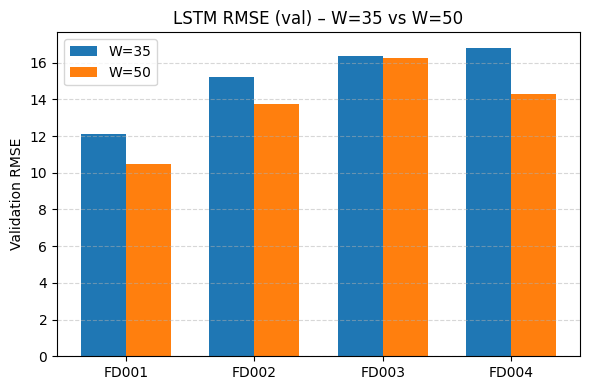

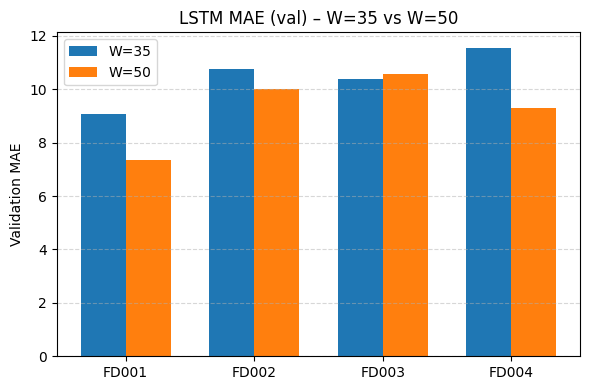

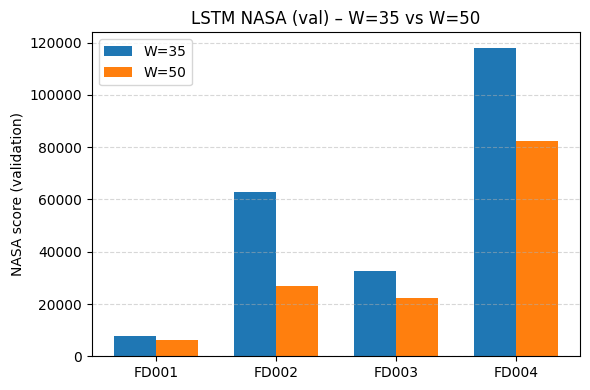

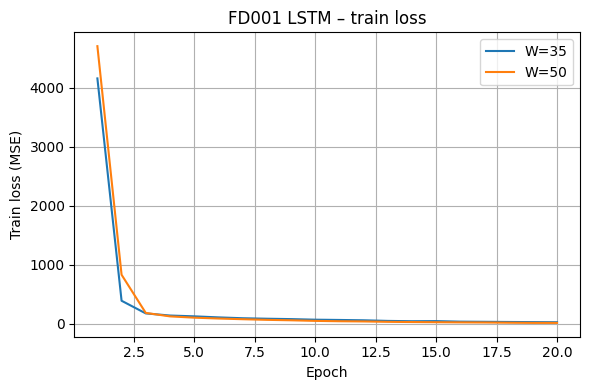

Saved figure to: FD001_rmse.png


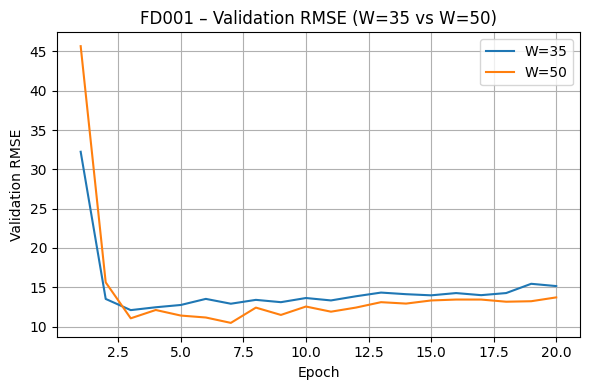

Saved figure to: FD001_mse.png


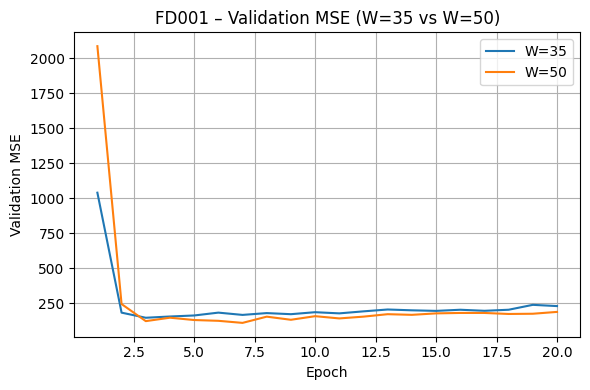

Saved figure to: FD001_nasa.png


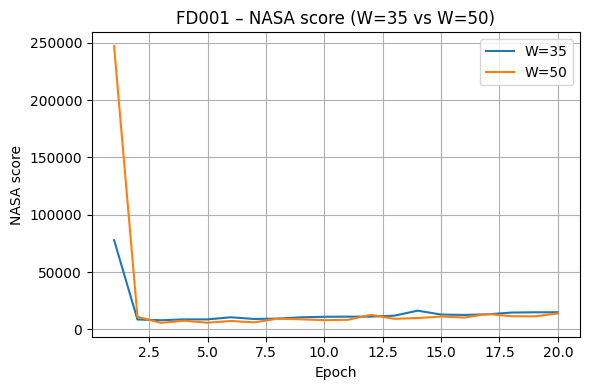

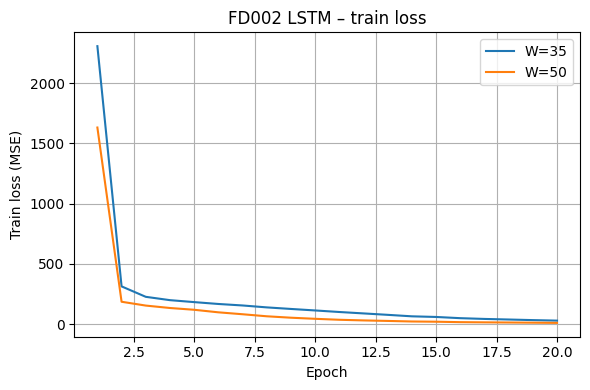

Saved figure to: FD002_rmse.png


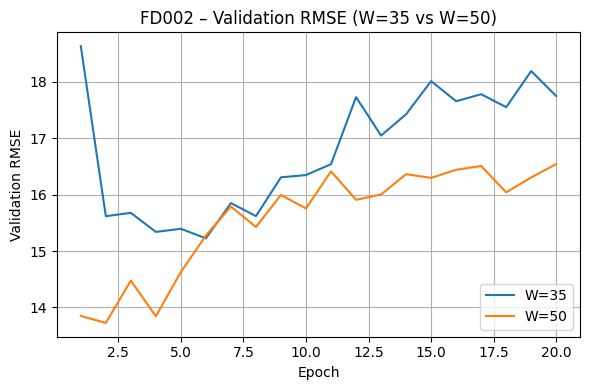

Saved figure to: FD002_mse.png


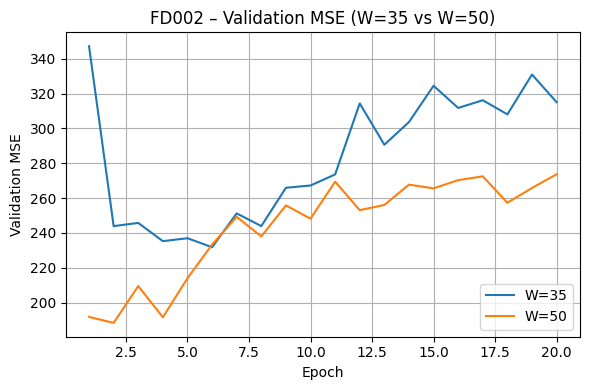

Saved figure to: FD002_nasa.png


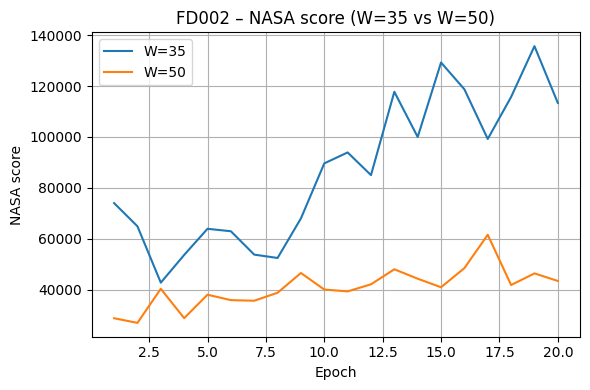

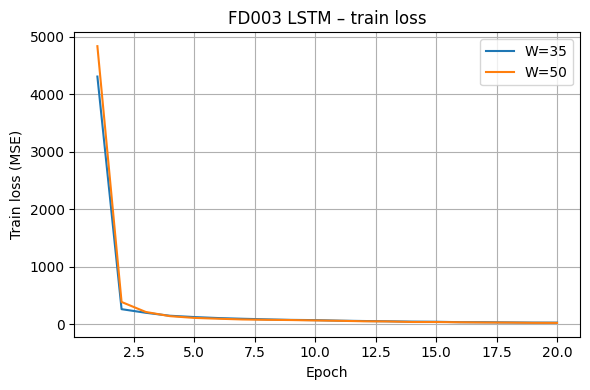

Saved figure to: FD003_rmse.png


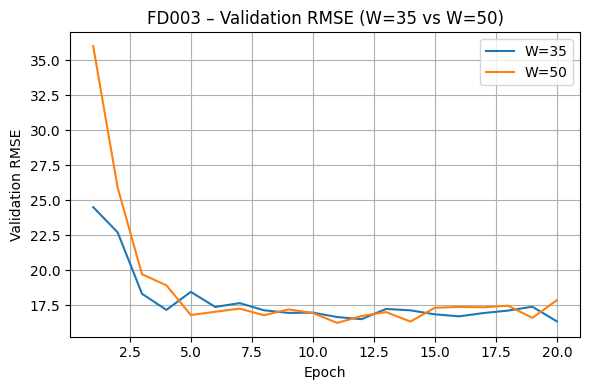

Saved figure to: FD003_mse.png


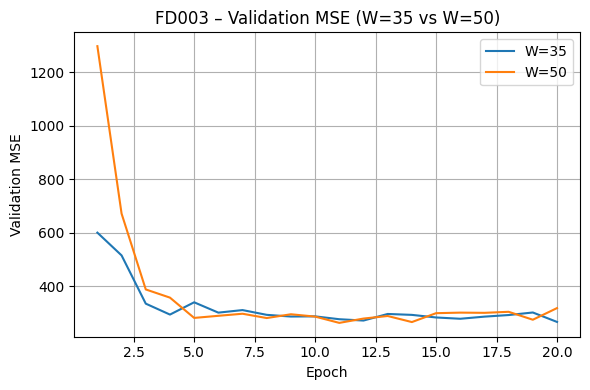

Saved figure to: FD003_nasa.png


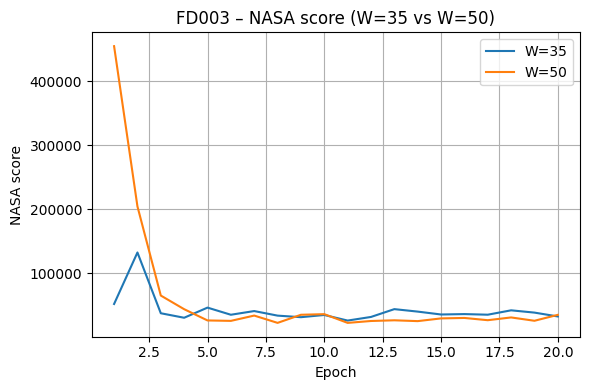

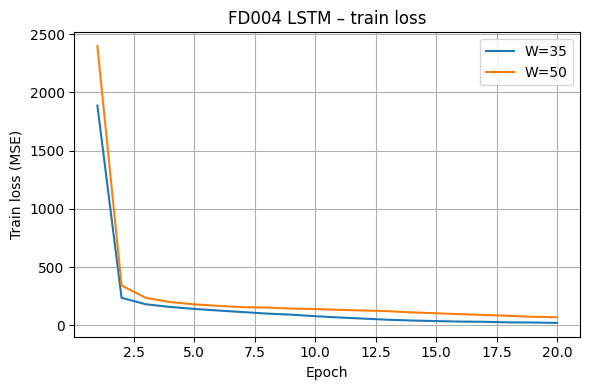

Saved figure to: FD004_rmse.png


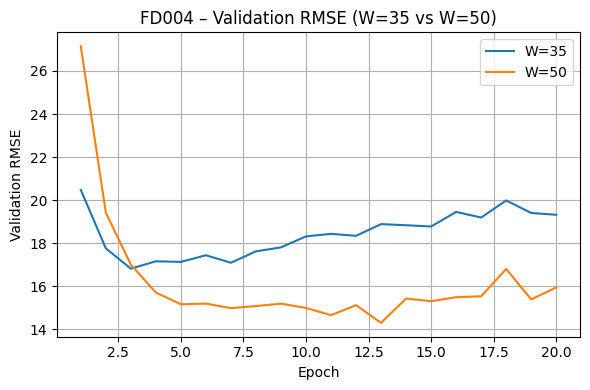

Saved figure to: FD004_mse.png


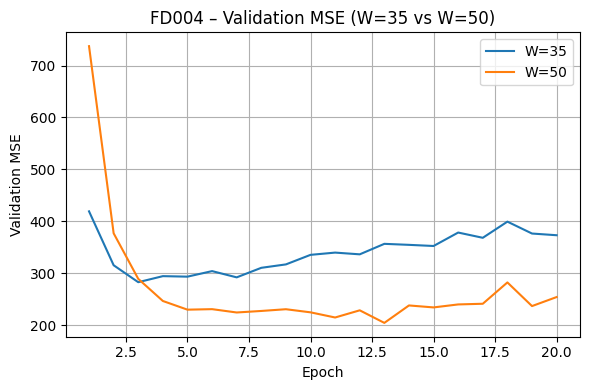

Saved figure to: FD004_nasa.png


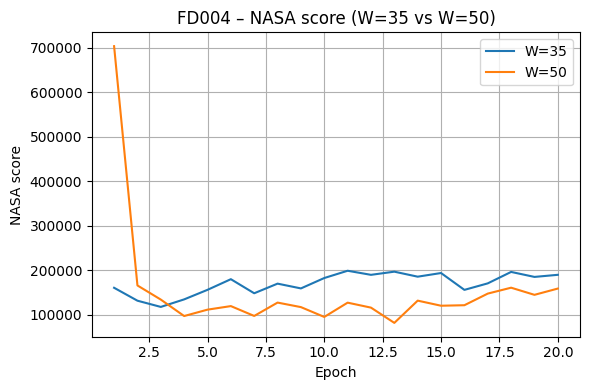

In [10]:
# Cell 10: summary table + plots

# ---- summary table ----
summary_rows = []
for fd in DATASETS:
    for w in WINDOWS:
        b = best_all[fd][w]
        summary_rows.append({
            "dataset": fd,
            "window": w,
            "best_epoch": b["epoch"],
            "rmse": b["rmse"],
            "mae": b["mae"],
            "mse": b["mse"],
            "nasa": b["nasa"],
        })

lstm_summary = pd.DataFrame(summary_rows)
print("\nLSTM summary (validation metrics):")
display(lstm_summary)


# ---- bar charts: W=35 vs W=50 ----

def plot_metric_bar(summary_df, metric_name, ylabel):
    """Grouped bar: each FD, compare w=35 vs w=50."""
    pivot = summary_df.pivot(index="dataset", columns="window", values=metric_name)
    datasets = pivot.index.tolist()
    x = np.arange(len(datasets))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, pivot[35].values, width=width, label="W=35")
    plt.bar(x + width/2, pivot[50].values, width=width, label="W=50")

    plt.xticks(x, datasets)
    plt.ylabel(ylabel)
    plt.title(f"LSTM {metric_name.upper()} (val) – W=35 vs W=50")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_metric_bar(lstm_summary, "rmse", "Validation RMSE")
plot_metric_bar(lstm_summary, "mae",  "Validation MAE")
plot_metric_bar(lstm_summary, "nasa", "NASA score (validation)")


# ---- per-dataset curves: train loss / val RMSE / val MSE / val NASA ----

def plot_train_loss(hist_dict, dataset_name):
    """Train loss vs epoch, W=35 vs 50, for one dataset."""
    df_35 = pd.DataFrame(hist_dict[35])
    df_50 = pd.DataFrame(hist_dict[50])

    plt.figure()
    plt.plot(df_35["epoch"], df_35["train_loss"], label="W=35")
    plt.plot(df_50["epoch"], df_50["train_loss"], label="W=50")
    plt.xlabel("Epoch")
    plt.ylabel("Train loss (MSE)")
    plt.title(f"{dataset_name} LSTM – train loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_val_metric(hist_dict, dataset_name, metric_key, metric_label, suffix):
    """Validation metric vs epoch, W=35 vs 50, for one dataset."""
    df_35 = pd.DataFrame(hist_dict[35])
    df_50 = pd.DataFrame(hist_dict[50])

    plt.figure()
    plt.plot(df_35["epoch"], df_35[metric_key], label="W=35")
    plt.plot(df_50["epoch"], df_50[metric_key], label="W=50")

    plt.xlabel("Epoch")
    plt.ylabel(metric_label)
    plt.title(f"{dataset_name} – {metric_label} (W=35 vs W=50)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fname = f"{dataset_name}_{suffix}.png"
    plt.savefig(fname, dpi=200)
    print("Saved figure to:", fname)
    plt.show()


for fd in DATASETS:
    plot_train_loss(hist_all[fd], fd)
    plot_val_metric(hist_all[fd], fd, "val_rmse", "Validation RMSE", "rmse")
    plot_val_metric(hist_all[fd], fd, "val_mse",  "Validation MSE",  "mse")
    plot_val_metric(hist_all[fd], fd, "val_nasa", "NASA score",      "nasa")
